# Trade with Python through MetaTrader5

In [1]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



True

In [24]:
# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)



In [25]:
ohlc_data

,Open,High,Low,Close,Volume
0,1.02308,1.02552,1.02299,1.02484,1783
1,1.02491,1.02692,1.02332,1.02458,6643
2,1.02455,1.02662,1.02092,1.02311,9484
3,1.02310,1.02512,1.02208,1.02368,6763
4,1.02369,1.02371,1.02198,1.02227,6172
...,...,...,...,...,...
715,1.08707,1.08890,1.08695,1.08821,4606
716,1.08821,1.08872,1.08781,1.08814,3168
717,1.08814,1.08855,1.08725,1.08792,3176
718,1.08791,1.08836,1.08773,1.08822,2599


In [26]:
data_dir = 'ohlc_data'
model_path = os.path.join(os.getcwd(), data_dir)

In [5]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [27]:
features_df = feature_generate(ohlc_data)
features_df_nonan = features_df.dropna().reset_index().drop(columns=['index'])
features_df_nonan = features_df_nonan.select_dtypes(exclude=['object'])


In [28]:
def features_selection(df, selection_method='all', topk=10, num_features=225):
    
    # Check if the columns exist before dropping
    columns_to_drop = ['Time', 'Date', 'Signal']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Separate features and target variable
    y = df['Signal']  # Target variable
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9999)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    list_features = X.columns.tolist()  # List of all feature names

    # Get indices of common features
    feat_idx = sorted([list_features.index(c) for c in lasso_selected_features][:num_features])
    print("Feature indices for common features:", feat_idx)

    return lasso_selected_features, feat_idx

def feature_generate(indicators_df):    
    # Moving Averages (Simple and Exponential)
    for window in [5, 10, 20, 50, 100, 200]:
        indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
        indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

    # Momentum Indicators
    indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                                  indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

    indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                      (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

    indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

    # Williams %R
    indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                     (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

    # Moving Average Convergence Divergence (MACD)
    indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
    indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
    indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

    # Average Directional Index (ADX)
    high_diff = indicators_df['High'].diff()
    low_diff = indicators_df['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    true_range = pd.DataFrame({
        'hl': indicators_df['High'] - indicators_df['Low'],
        'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
        'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
    }).max(axis=1)
    indicators_df['ATR'] = true_range.rolling(window=14).mean()
    indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

    # Commodity Channel Index (CCI)
    typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Bollinger Bands
    indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
    indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

    # Rate of Change (ROC)
    indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

    # On-Balance Volume (OBV)
    obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
                   np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
    indicators_df['OBV'] = obv.cumsum()

    # Force Index
    indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

    # Accumulation/Distribution Line (ADL)
    adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
           (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
    indicators_df['ADL'] = adl.cumsum()

    # Money Flow Index (MFI)
    money_flow = typical_price * indicators_df['Volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
    indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    # Accumulation Swing Index (ASI)
    indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                            (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                            (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

    # Chaikin Oscillator
    indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()

    # Relative Strength (RS)
    indicators_df['RS'] = indicators_df['Close'] / indicators_df['Close'].rolling(14).mean()

    # Keltner Channels
    indicators_df['Keltner_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Keltner_Upper'] = indicators_df['Keltner_Mid'] + 1.5 * indicators_df['ATR']
    indicators_df['Keltner_Lower'] = indicators_df['Keltner_Mid'] - 1.5 * indicators_df['ATR']

    # Donchian Channels
    indicators_df['Donchian_Upper'] = indicators_df['High'].rolling(window=20).max()
    indicators_df['Donchian_Lower'] = indicators_df['Low'].rolling(window=20).min()

    # Ichimoku Cloud
    indicators_df['Tenkan_Sen'] = (indicators_df['High'].rolling(9).max() + indicators_df['Low'].rolling(9).min()) / 2
    indicators_df['Kijun_Sen'] = (indicators_df['High'].rolling(26).max() + indicators_df['Low'].rolling(26).min()) / 2
    indicators_df['Senkou_Span_A'] = ((indicators_df['Tenkan_Sen'] + indicators_df['Kijun_Sen']) / 2).shift(26)
    indicators_df['Senkou_Span_B'] = ((indicators_df['High'].rolling(52).max() + indicators_df['Low'].rolling(52).min()) / 2).shift(26)

    # Fibonacci Retracement Levels
    indicators_df['Fib_0'] = indicators_df['Close'].rolling(window=20).min()
    indicators_df['Fib_100'] = indicators_df['Close'].rolling(window=20).max()
    indicators_df['Fib_50'] = (indicators_df['Fib_0'] + indicators_df['Fib_100']) / 2
    indicators_df['Fib_61.8'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.618)
    indicators_df['Fib_38.2'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.382)

        # Double/Triple Tops and Bottoms
    indicators_df['Double_Top'] = (indicators_df['High'].rolling(window=3).max() == indicators_df['High'])
    indicators_df['Double_Bottom'] = (indicators_df['Low'].rolling(window=3).min() == indicators_df['Low'])

    # Price Channels
    indicators_df['Channel_High'] = indicators_df['High'].rolling(window=20).max()
    indicators_df['Channel_Low'] = indicators_df['Low'].rolling(window=20).min()
    indicators_df['Channel_Mid'] = (indicators_df['Channel_High'] + indicators_df['Channel_Low']) / 2

    # Linear Regression Channels
    def linear_regression_channel(series, window):
        x = np.arange(window)
        fit = lambda y: np.polyfit(x, y, 1)
        slope, intercept = series.rolling(window).apply(lambda y: fit(y)[0], raw=False), series.rolling(window).apply(lambda y: fit(y)[1], raw=False)
        center = slope * (window - 1) + intercept
        std = series.rolling(window).std()
        return center, center + 2 * std, center - 2 * std

    lr_center, lr_upper, lr_lower = linear_regression_channel(indicators_df['Close'], 20)
    indicators_df['LR_Center'] = lr_center
    indicators_df['LR_Upper'] = lr_upper
    indicators_df['LR_Lower'] = lr_lower

    # Parabolic SAR (Modified for Channels)
    sar = indicators_df['Low'].rolling(window=14).min()
    indicators_df['SAR'] = sar.shift(1)

    # Standard Deviation Channels
    std = indicators_df['Close'].rolling(window=20).std()
    mean = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Std_Dev_Upper'] = mean + 2 * std
    indicators_df['Std_Dev_Lower'] = mean - 2 * std

    # VWAP Bands
    indicators_df['VWAP'] = (indicators_df['Close'] * indicators_df['Volume']).cumsum() / indicators_df['Volume'].cumsum()
    indicators_df['VWAP_Upper'] = indicators_df['VWAP'] + std
    indicators_df['VWAP_Lower'] = indicators_df['VWAP'] - std

    # Adaptive Channels
    atr = indicators_df['Close'].rolling(window=14).std()
    indicators_df['Adaptive_Upper'] = indicators_df['Close'] + (2 * atr)
    indicators_df['Adaptive_Lower'] = indicators_df['Close'] - (2 * atr)

    # Heikin-Ashi
    ha_close = (indicators_df['Open'] + indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 4
    indicators_df['HA_Close'] = ha_close
    indicators_df['HA_Open'] = ha_close.shift(1)

    # Pivot Points
    pivot = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['Pivot_Point'] = pivot
    indicators_df['Pivot_R1'] = (2 * pivot) - indicators_df['Low']
    indicators_df['Pivot_S1'] = (2 * pivot) - indicators_df['High']

    
    return indicators_df


In [8]:
features_df_nonan.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100',
       'SMA_200', 'EMA_200', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
       'Williams_%R', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ATR', 'Plus_DI',
       'Minus_DI', 'ADX', 'CCI', 'Bollinger_Mid', 'Bollinger_Upper',
       'Bollinger_Lower', 'ROC', 'OBV', 'Force_Index', 'ADL', 'MFI', 'ASI',
       'Chaikin_Oscillator', 'RS', 'Keltner_Mid', 'Keltner_Upper',
       'Keltner_Lower', 'Donchian_Upper', 'Donchian_Lower', 'Tenkan_Sen',
       'Kijun_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Fib_0', 'Fib_100',
       'Fib_50', 'Fib_61.8', 'Fib_38.2', 'Double_Top', 'Double_Bottom',
       'Channel_High', 'Channel_Low', 'Channel_Mid', 'LR_Center', 'LR_Upper',
       'LR_Lower', 'SAR', 'Std_Dev_Upper', 'Std_Dev_Lower', 'VWAP',
       'VWAP_Upper', 'VWAP_Lower', 'Adaptive_Upper', 'Adaptive_Lower',
       'HA_Close', 'HA_Open', 'Pivot_Point', 'Pi

<Axes: >

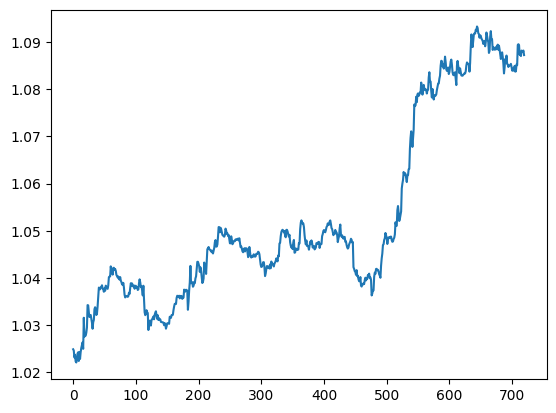

In [29]:
ohlc_data['Close'].plot()

<Axes: >

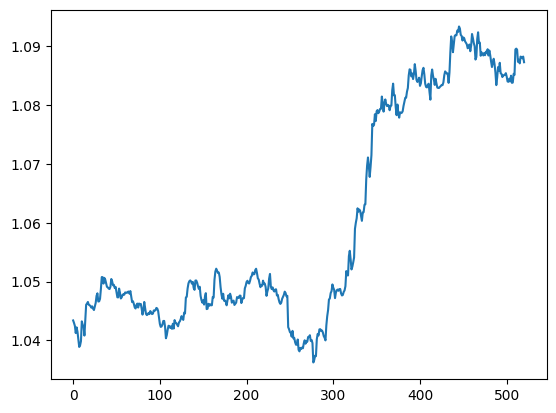

In [30]:
features_df_nonan['Close'].plot()

In [31]:
feat_idx_ = [1, 2, 3, 4, 5, 6, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 55]
features_df_nonan = features_df_nonan.iloc[:, feat_idx_]


In [32]:
features_df_nonan

,High,Low,Close,Volume,SMA_5,EMA_5,SMA_50,SMA_100,SMA_200,EMA_200,...,Donchian_Lower,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Fib_100,Fib_61.8,Fib_38.2,Double_Top,Double_Bottom
0,1.04376,1.04296,1.04340,2722,1.041758,1.042018,1.036109,1.034587,1.034540,1.033861,...,1.03160,1.040825,1.037680,1.034830,1.033585,1.04340,1.039511,1.037109,True,False
1,1.04391,1.04278,1.04298,3449,1.042378,1.042339,1.036362,1.034633,1.034631,1.033952,...,1.03160,1.040900,1.037755,1.034793,1.033585,1.04340,1.039511,1.037109,True,False
2,1.04357,1.04216,1.04247,4953,1.042810,1.042382,1.036603,1.034679,1.034720,1.034037,...,1.03160,1.041030,1.037755,1.034928,1.033585,1.04340,1.039511,1.037109,False,True
3,1.04256,1.04091,1.04126,5007,1.042700,1.042008,1.036820,1.034712,1.034811,1.034108,...,1.03160,1.041270,1.037755,1.034982,1.033585,1.04340,1.039511,1.037109,False,True
4,1.04255,1.04101,1.04223,4140,1.042468,1.042082,1.037060,1.034760,1.034904,1.034189,...,1.03243,1.041270,1.037755,1.035270,1.033585,1.04340,1.040164,1.038166,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,1.08890,1.08695,1.08821,4606,1.087932,1.087756,1.086920,1.087657,1.081804,1.079625,...,1.08297,1.087310,1.087075,1.086365,1.088390,1.08957,1.087347,1.085973,True,False
517,1.08872,1.08781,1.08814,3168,1.087682,1.087884,1.086836,1.087704,1.081990,1.079710,...,1.08297,1.087895,1.087075,1.086362,1.088390,1.08957,1.087347,1.085973,False,False
518,1.08855,1.08725,1.08792,3176,1.087802,1.087896,1.086785,1.087739,1.082158,1.079792,...,1.08297,1.088125,1.087075,1.086362,1.088390,1.08957,1.087347,1.085973,False,False
519,1.08836,1.08773,1.08822,2599,1.087910,1.088004,1.086737,1.087785,1.082323,1.079876,...,1.08297,1.088755,1.087075,1.086362,1.088390,1.08957,1.087347,1.085973,False,False


In [52]:
len(features_df_nonan.columns)

42

In [34]:
X = features_df_nonan.values

# Choose between MinMaxScaler or StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # For Min-Max scaling
x_tran = scaler.fit_transform(X)
x_tran = x_tran.reshape((x_tran.shape[0], x_tran.shape[1], 1))

# Normalize data if not already normalized
x_tran = x_tran / np.max(x_tran)


In [35]:
# Open in the old TensorFlow version
from tensorflow.keras.models import load_model
model = load_model(os.path.join(os.getcwd(), data_dir, "model.hd5"))


In [36]:
# Get predictions
y_pred = model.predict(x_tran)  # This returns probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices


17/17 [==============================] - 0s 1ms/step


In [37]:
y_pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [38]:
def transform_array_with_rules(arr):
    """Transforms the input array based on the specified rules:
       - Keep the first occurrence of 1s and 2s.
       - Replace consecutive ones with 0s, except for the last occurrence which becomes -1.
       - Replace consecutive twos with 0s, except for the last occurrence which becomes -2.
    """
    transformed = np.zeros_like(arr)  # Initialize an array of zeros
    transformed[0] = arr[0]  # Keep the first element unchanged
    
    i = 1
    while i < len(arr):
        if arr[i] == 1:
            transformed[i] = 1  # Keep the first 1
            j = i + 1
            while j < len(arr) and arr[j] == 1:
                transformed[j] = 0  # Set consecutive 1s to 0
                j += 1
            if j - 1 > i:  # If there were multiple consecutive 1s, set the last one to -1
                transformed[j - 1] = -1
            i = j  # Move the index forward

        elif arr[i] == 2:
            transformed[i] = 2  # Keep the first 2
            j = i + 1
            while j < len(arr) and arr[j] == 2:
                transformed[j] = 0  # Set consecutive 2s to 0
                j += 1
            if j - 1 > i:  # If there were multiple consecutive 2s, set the last one to -2
                transformed[j - 1] = -2
            i = j  # Move the index forward

        else:
            transformed[i] = arr[i]  # Keep other values unchanged
            i += 1
    
    transformed[len(arr)-1] = arr[len(arr)-1] 
    
    return transformed




In [39]:
# Transforming the input array using the specified rules
transformed_array_rules = transform_array_with_rules(y_pred_classes)
transformed_array_rules

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  1, -1,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0, -1,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  1, -1,  0,  0,  1,  0,  0,  0,  0, -1,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0

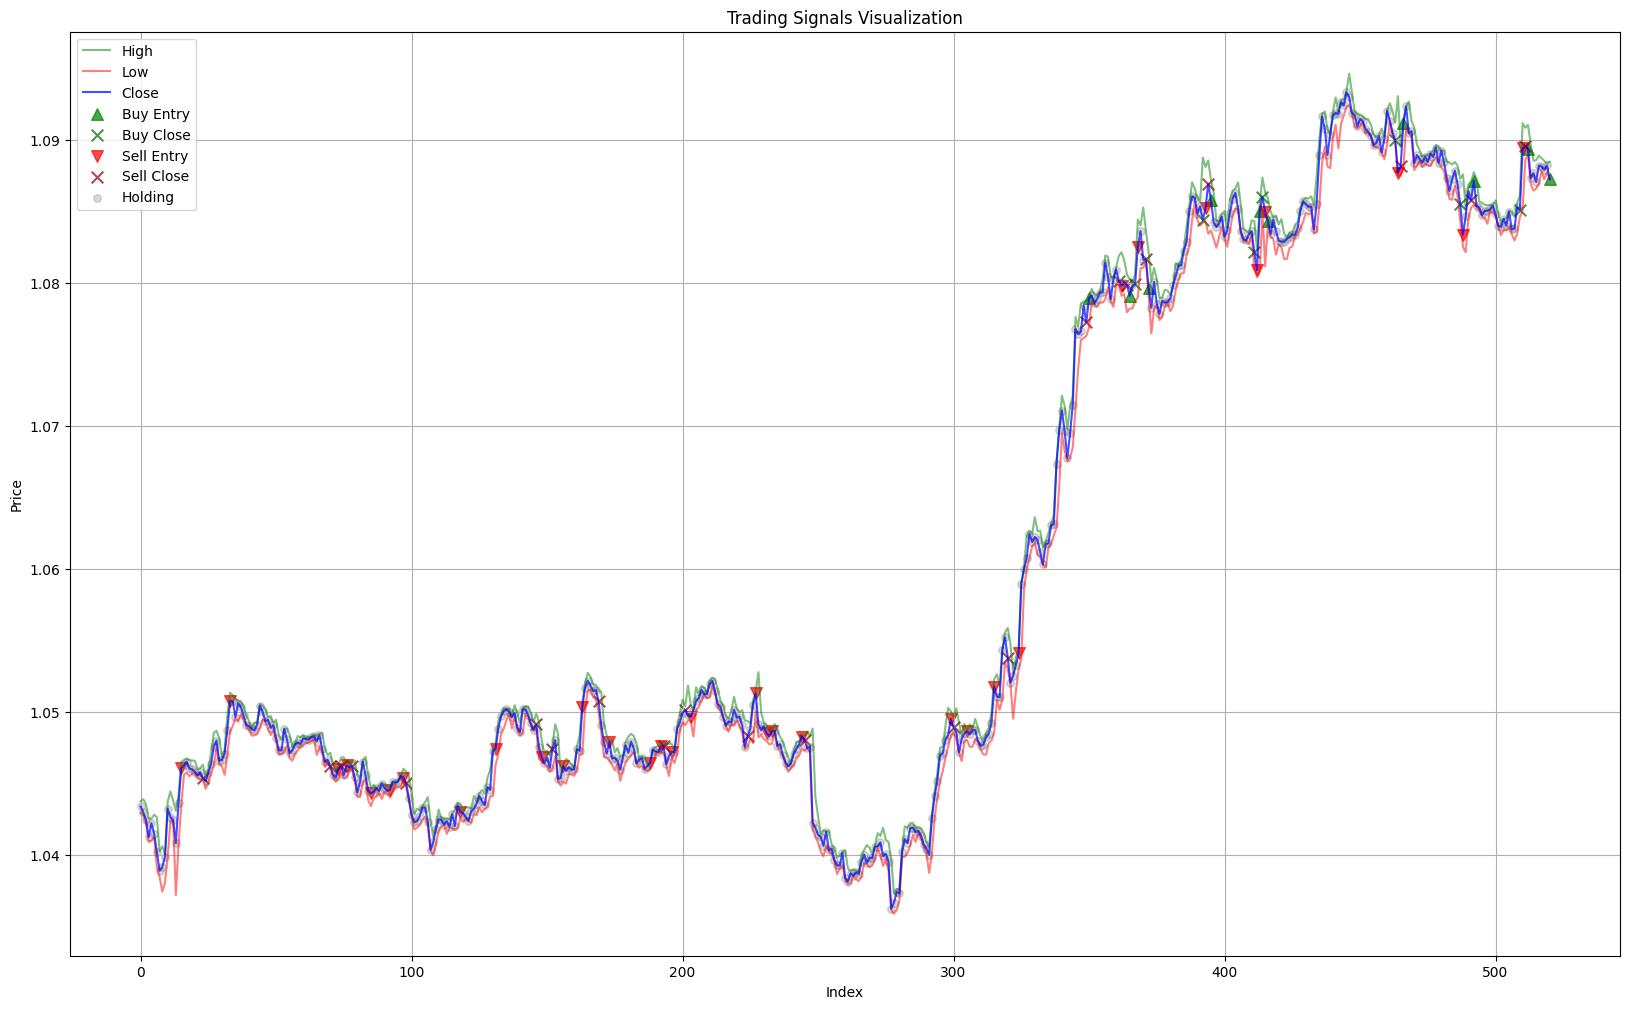

In [40]:
plot_trading_signals(features_df_nonan, transformed_array_rules)

In [42]:
import matplotlib.pyplot as plt

def plot_trading_signals(features_df_nonan, y_pred_classes):
    """
    Plots the High, Low, and Close prices along with trading signals.
    Trading signals:
    - 1: Sell
    - -1: Sell Close
    - 2: Buy
    - -2: Buy Close
    - 0: In position between Buy and Buy Close OR Sell and Sell Close
    """

    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot High, Low, Close prices
    ax.plot(features_df_nonan.index, features_df_nonan['High'], label="High", color='g', alpha=0.5)
    ax.plot(features_df_nonan.index, features_df_nonan['Low'], label="Low", color='r', alpha=0.5)
    ax.plot(features_df_nonan.index, features_df_nonan['Close'], label="Close", color='b', alpha=0.7)

    # Convert signals into a NumPy array for plotting
    signals = np.array(y_pred_classes)

    # Identify different signals
    buy_signals = np.where(signals == 2)[0]       # Buy entry
    buy_close_signals = np.where(signals == -2)[0] # Buy exit
    sell_signals = np.where(signals == 1)[0]      # Sell entry
    sell_close_signals = np.where(signals == -1)[0] # Sell exit
    in_position = np.where(signals == 0)[0]       # Holding between entry & exit

    # Mark Buy entry
    ax.scatter(features_df_nonan.index[buy_signals], features_df_nonan['Close'].iloc[buy_signals],
               marker='^', color='green', label="Buy Entry", s=70, alpha=0.7)

    # Mark Buy exit
    ax.scatter(features_df_nonan.index[buy_close_signals], features_df_nonan['Close'].iloc[buy_close_signals],
               marker='x', color='darkgreen', label="Buy Close", s=70, alpha=0.7)

    # Mark Sell entry
    ax.scatter(features_df_nonan.index[sell_signals], features_df_nonan['Close'].iloc[sell_signals],
               marker='v', color='red', label="Sell Entry", s=70, alpha=0.7)

    # Mark Sell exit
    ax.scatter(features_df_nonan.index[sell_close_signals], features_df_nonan['Close'].iloc[sell_close_signals],
               marker='x', color='darkred', label="Sell Close", s=70, alpha=0.7)

    # Mark Holding periods (in position between buy/sell and their closes)
    ax.scatter(features_df_nonan.index[in_position], features_df_nonan['Close'].iloc[in_position],
               marker='o', color='gray', label="Holding", s=30, alpha=0.3)

    # Titles and labels
    ax.set_title("Trading Signals Visualization")
    ax.set_xlabel("Index")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid()

    # Show the plot
    plt.show()

# Assuming features_df_nonan and y_pred_classes are provided, you can call:
# plot_trading_signals(features_df_nonan, y_pred_classes)


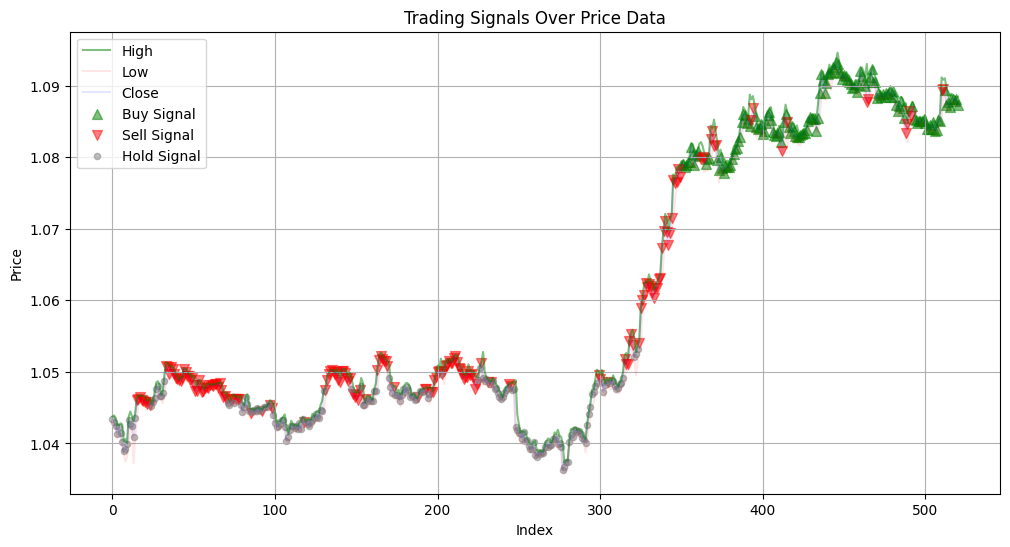

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming features_df_nonan is a pandas DataFrame
# with columns 'High', 'Low', 'Close' and has 157 rows
fig, ax = plt.subplots(figsize=(12, 6))

# Plot High, Low, Close prices
ax.plot(features_df_nonan.index, features_df_nonan['High'], label="High", color='g', alpha=0.5)
ax.plot(features_df_nonan.index, features_df_nonan['Low'], label="Low", color='r', alpha=0.1)
ax.plot(features_df_nonan.index, features_df_nonan['Close'], label="Close", color='b', alpha=0.1)

# Convert signals into a NumPy array for plotting
signals = np.array(y_pred_classes)

# Plot signals with different markers
buy_signals = np.where(signals == 2)[0]  # Buy (2)
sell_signals = np.where(signals == 1)[0] # Sell (1)
hold_signals = np.where(signals == 0)[0] # Hold (0)

# Mark Buy signals
ax.scatter(features_df_nonan.index[buy_signals], features_df_nonan['Close'].iloc[buy_signals],
           marker='^', color='green', label="Buy Signal", s=50, alpha=0.5)

# Mark Sell signals
ax.scatter(features_df_nonan.index[sell_signals], features_df_nonan['Close'].iloc[sell_signals],
           marker='v', color='red', label="Sell Signal", s=50, alpha=0.5)

# Mark Hold signals
ax.scatter(features_df_nonan.index[hold_signals], features_df_nonan['Close'].iloc[hold_signals],
           marker='o', color='gray', label="Hold Signal", s=20, alpha=0.5)

# Titles and labels
ax.set_title("Trading Signals Over Price Data")
ax.set_xlabel("Index")
ax.set_ylabel("Price")
ax.legend()
ax.grid()

plt.show()


In [6]:
# get account info
account_info = mt.account_info()
print(account_info)

# getting specific account data
login_number = account_info.login
balance = account_info.balance
equity = account_info.equity

print()
print('login: ', login_number)
print('balance: ', balance)
print('equity: ', equity)

AccountInfo(login=165905041, trade_mode=0, leverage=1000, limit_orders=300, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=10000.0, credit=0.0, profit=0.0, equity=10000.0, margin=0.0, margin_free=10000.0, margin_level=0.0, margin_so_call=50.0, margin_so_so=20.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Demo Account', server='XMGlobal-MT5 2', currency='USD', company='XM Global Limited')

login:  165905041
balance:  10000.0
equity:  10000.0


In [5]:
request = {
        "action":mt.TRADE_ACTION_DEAL,
        "symbol":'EURUSD',
        "type" : mt.ORDER_TYPE_BUY,
        "price": mt.symbol_info_tick("EURUSD").ask,
        "volume":0.01,
        "deviation": 200,
        "comment":'Test_code',
        "type_filling":mt.ORDER_FILLING_IOC
}

mt.order_send(request)

OrderSendResult(retcode=10027, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='AutoTrading disabled by client', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=0.01, price=1.04309, stoplimit=0.0, sl=0.0, tp=0.0, deviation=200, type=0, type_filling=1, type_time=0, expiration=0, comment='Test_code', position=0, position_by=0))

In [32]:
# get number of symbols with symbols_total()
num_symbols = mt.symbols_total()

num_symbols

1506

In [6]:
# get all symbols and their specifications
symbols = mt.symbols_get()
# symbols

In [7]:
# Extract currency pair names
currency_pairs = [symbol.name for symbol in symbols if 'Forex\\Standard\\Majors\\' in symbol.path]

print(currency_pairs)

['CADCHF', 'CADJPY', 'CHFJPY', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'USDCAD', 'USDCHF', 'USDJPY']


In [11]:
import os
p = r'D:\git_repos\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data'
df = pd.read_csv(os.path.join(p,'EURUSD','H1_EURUSD_2015.csv'), index_col=0)

In [14]:
pd.to_datetime(df['time'].iloc[-1], unit='s')

Timestamp('2024-12-20 14:00:00')

In [13]:
df.iloc[-1]

time           1.734703e+09
open           1.039060e+00
high           1.039920e+00
low            1.038690e+00
close          1.038850e+00
tick_volume    3.749000e+03
spread         1.700000e+01
real_volume    0.000000e+00
Name: 61937, dtype: float64

In [15]:
import os
import pandas as pd
from datetime import datetime, timedelta
import MetaTrader5 as mt5

# List of pairs to download
pairs = ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCHF', 'USDCAD']

# Function to create necessary directories, check files, and save or update data
def download_ohlc_data(symbol, start_year):
    # Base directory for saving files
    base_dir = f'ohlc_data/{symbol}'
    
    # Create the directory for the symbol if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    file_path = os.path.join(base_dir, f'H1_{symbol}_{start_year}.csv')

    # If the file doesn't exist, download data
    if not os.path.exists(file_path):
        print(f"Downloading data for {symbol} from {start_year}...")
        ohlc_data = pd.DataFrame(mt5.copy_rates_range(symbol, 
                                                      mt5.TIMEFRAME_H1, 
                                                      datetime(start_year, 1, 1), 
                                                      datetime.now()))
        # Check if data was retrieved successfully
        if not ohlc_data.empty:
            ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
            ohlc_data.to_csv(file_path, index=False)
            print(f"Downloaded and saved data for {symbol} ({start_year})")
        else:
            print(f"No data found for {symbol} ({start_year})")
    else:
        # File exists, check if it needs updating
        print(f"Checking for updates for {symbol}...")
        rates_frame = pd.read_csv(file_path)
        rates_frame['time'] = pd.to_datetime(rates_frame['time'])
        
        # Check the last row's time
        last_row_time = rates_frame['time'].iloc[-1]
        if last_row_time < datetime.now() - timedelta(days=2):
            print(f"Updating data for {symbol}...")
            utc_from = last_row_time + timedelta(seconds=1)
            utc_to = datetime.now()
            
            # Retrieve new data
            new_data = pd.DataFrame(mt5.copy_rates_range(symbol, 
                                                         mt5.TIMEFRAME_H1, 
                                                         utc_from, 
                                                         utc_to))
            if not new_data.empty:
                new_data['time'] = pd.to_datetime(new_data['time'], unit='s')
                updated_data = pd.concat([rates_frame, new_data]).drop_duplicates(subset='time')
                updated_data.to_csv(file_path, index=False)
                print(f"Updated data for {symbol}.")
            else:
                print(f"No new data available for {symbol}.")
        else:
            print(f"Data for {symbol} is already up-to-date.")

# Connect to MetaTrader 5
if not mt5.initialize():
    print("MetaTrader5 initialization failed!")
else:
    # Define the starting year
    start_year = 2015

    # Download or update data for each currency pair
    for pair in pairs:
        download_ohlc_data(pair, start_year)

    # Shutdown MetaTrader 5 after completing tasks
    mt5.shutdown()


Checking for updates for EURUSD...
Updating data for EURUSD...
No new data available for EURUSD.
Checking for updates for GBPUSD...
Updating data for GBPUSD...
No new data available for GBPUSD.
Checking for updates for USDJPY...
Updating data for USDJPY...
No new data available for USDJPY.
Checking for updates for AUDUSD...
Updating data for AUDUSD...
No new data available for AUDUSD.
Checking for updates for USDCHF...
Updating data for USDCHF...
No new data available for USDCHF.
Checking for updates for USDCAD...
Updating data for USDCAD...
No new data available for USDCAD.


In [34]:
# get symbol specifications
symbol_info = mt.symbol_info("EURUSD")._asdict()
symbol_info

{'custom': False,
 'chart_mode': 0,
 'select': True,
 'visible': True,
 'session_deals': 0,
 'session_buy_orders': 0,
 'session_sell_orders': 0,
 'volume': 0,
 'volumehigh': 0,
 'volumelow': 0,
 'time': 1734708625,
 'digits': 5,
 'spread': 27,
 'spread_float': True,
 'ticks_bookdepth': 0,
 'trade_calc_mode': 0,
 'trade_mode': 4,
 'start_time': 0,
 'expiration_time': 0,
 'trade_stops_level': 0,
 'trade_freeze_level': 0,
 'trade_exemode': 2,
 'swap_mode': 1,
 'swap_rollover3days': 3,
 'margin_hedged_use_leg': False,
 'expiration_mode': 15,
 'filling_mode': 2,
 'order_mode': 127,
 'order_gtc_mode': 0,
 'option_mode': 0,
 'option_right': 0,
 'bid': 1.04041,
 'bidhigh': 1.04063,
 'bidlow': 1.03419,
 'ask': 1.04068,
 'askhigh': 1.04087,
 'asklow': 1.0344,
 'last': 0.0,
 'lasthigh': 0.0,
 'lastlow': 0.0,
 'volume_real': 0.0,
 'volumehigh_real': 0.0,
 'volumelow_real': 0.0,
 'option_strike': 0.0,
 'point': 1e-05,
 'trade_tick_value': 1.0,
 'trade_tick_value_profit': 1.0,
 'trade_tick_value_los

In [35]:
# get current symbol price
symbol_price = mt.symbol_info_tick("EURUSD")._asdict()
symbol_price

{'time': 1734708627,
 'bid': 1.04066,
 'ask': 1.04089,
 'last': 0.0,
 'volume': 0,
 'time_msc': 1734708627048,
 'flags': 1124,
 'volume_real': 0.0}

In [39]:
ohlc_data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1420048800,1.20997,1.21089,1.20966,1.20999,3237,17,0
1,1420185600,1.20481,1.20569,1.20479,1.20538,1254,17,0
2,1420189200,1.20537,1.20574,1.20341,1.20553,3394,17,0
3,1420192800,1.20556,1.20689,1.20442,1.20469,4590,17,0
4,1420196400,1.20468,1.20599,1.20380,1.20573,4335,17,0
...,...,...,...,...,...,...,...,...
61932,1734685200,1.03737,1.03842,1.03715,1.03817,5316,17,0
61933,1734688800,1.03816,1.03974,1.03770,1.03913,5104,17,0
61934,1734692400,1.03913,1.03915,1.03749,1.03817,4389,17,0
61935,1734696000,1.03818,1.03921,1.03803,1.03908,3521,17,0


<Axes: >

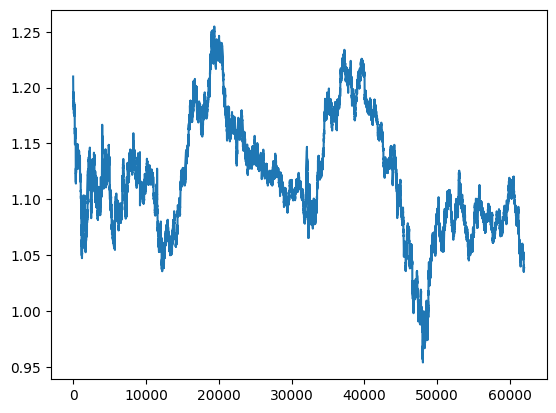

In [22]:
ohlc_data['close'].plot()

In [5]:
# ohlc_data
ohlc_data = pd.DataFrame(mt.copy_rates_range("EURUSD", 
                                             mt.TIMEFRAME_H4, 
                                             datetime(2015, 1, 1), 
                                             datetime.now()))
ohlc_data.to_csv('H4_EURUSD_2015.csv')

In [9]:

# ohlc_data
ohlc_data = pd.DataFrame(mt.copy_rates_range("EURUSD", 
                                             mt.TIMEFRAME_D1, 
                                             datetime(2015, 1, 1), 
                                             datetime.now()))
ohlc_data.to_csv('D1_EURUSD_2015.csv')
# ohlc_data
ohlc_data = pd.DataFrame(mt.copy_rates_range("EURUSD", 
                                             mt.TIMEFRAME_M30, 
                                             datetime(2015, 1, 1), 
                                             datetime.now()))
ohlc_data.to_csv('M30_EURUSD_2015.csv')


In [21]:
symbol ="EURUSD"
end_time = datetime.now()
timeframe = mt.TIMEFRAME_M30
start_time = datetime(2015, 1, 1)

rates = mt.copy_rates_range(symbol, timeframe, start_time, datetime.now())

if rates is not None:
    print("Data downloaded successfully!")
    # Print the downloaded data
#     for rate in rates:
#         print('Printing first sample: ', rate)
#         break

    ohlc_data = pd.DataFrame(rates)
    ohlc_data.to_csv('M30_EURUSD_2015.csv')
    
else:
    print("Data not available for the specified time range.")

    # Loop to try pulling most recent available data
    while True:
        start_time = end_time - timedelta(days=365)  # Adjust this period as needed
        rates = mt.copy_rates_range(symbol, timeframe, start_time, end_time)
        
#         if rates is not None:
#             print("Most recent data downloaded successfully!")
            # Print the downloaded data
#             for rate in rates:
#                 print(rate)
#             break
        if rates is None:
            print("Failed to download most recent data. Trying again...")
        else:
            print("Data downloaded successfully!")
            ohlc_data = pd.DataFrame(rates)
            ohlc_data.to_csv('M30_EURUSD_2015.csv')
            break

Data not available for the specified time range.
Data downloaded successfully!


In [20]:
ohlc_data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1684108800,1.08608,1.08608,1.08500,1.08533,101,22,0
1,1684110600,1.08530,1.08544,1.08521,1.08522,84,29,0
2,1684112400,1.08520,1.08520,1.08446,1.08498,623,16,0
3,1684114200,1.08498,1.08520,1.08489,1.08491,443,17,0
4,1684116000,1.08492,1.08512,1.08469,1.08509,451,16,0
...,...,...,...,...,...,...,...,...
12379,1715376600,1.07699,1.07726,1.07688,1.07726,855,18,0
12380,1715378400,1.07725,1.07748,1.07712,1.07736,1007,18,0
12381,1715380200,1.07736,1.07736,1.07707,1.07707,865,18,0
12382,1715382000,1.07707,1.07712,1.07689,1.07706,388,20,0


In [26]:
ohlc_data = pd.DataFrame(mt.copy_rates_range("EURUSD", 
                                             mt.TIMEFRAME_M30, 
                                             datetime(2015, 1, 1), 
                                             datetime.now()))
ohlc_data.to_csv('M30_EURUSD_2015.csv')

In [14]:
ohlc_data.to_csv('H4_EURUSD_2015.csv')

<Axes: >

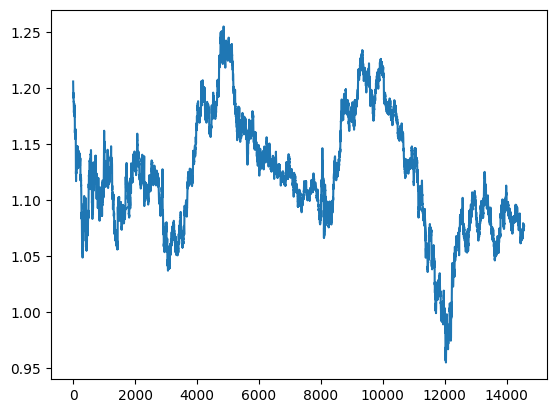

In [15]:
ohlc_data.close.plot()

In [17]:
ohlc_data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1420185600,1.20481,1.20689,1.20341,1.20573,13573,17,0
1,1420200000,1.20573,1.20576,1.20248,1.20303,11302,17,0
2,1420214400,1.20302,1.20329,1.20031,1.20090,16214,17,0
3,1420228800,1.20093,1.20149,1.19993,1.20002,5820,17,0
4,1420416000,1.19511,1.19754,1.18599,1.19539,15220,17,0
...,...,...,...,...,...,...,...,...
14561,1715313600,1.07783,1.07817,1.07721,1.07730,3353,18,0
14562,1715328000,1.07729,1.07858,1.07706,1.07797,8836,18,0
14563,1715342400,1.07800,1.07852,1.07653,1.07691,9909,18,0
14564,1715356800,1.07695,1.07891,1.07594,1.07749,14820,18,0


In [12]:
# requesting tick data
tick_data = pd.DataFrame(mt.copy_ticks_range("EURUSD", 
                                             datetime(2023, 10, 4), 
                                             datetime.now(), 
                                             mt.COPY_TICKS_ALL))

fig = px.line(tick_data, x=tick_data['time'], y=[tick_data['bid'], tick_data['ask']])
fig.show()

# tick_data

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [39]:
# total number of orders
num_orders = mt.orders_total()
num_orders

0

In [38]:
# list of orders
orders = mt.orders_get()
orders

()

In [37]:
# total number of positions
num_positions = mt.positions_total()
num_positions

0

In [95]:
# list of positions
positions = mt.positions_get()
positions

()

In [106]:
# number of history orders
num_order_history = mt.history_orders_total(datetime(2021, 1, 1), datetime(2021, 10, 6))
num_order_history

0

In [97]:
# list of history orders
order_history = mt.history_orders_get(datetime(2021, 1, 1), datetime(2021, 10, 6))
order_history

()

In [98]:
# number of history deals
num_deal_history = mt.history_deals_total(datetime(2021, 1, 1),  datetime(2021, 10, 6))
num_deal_history

0

In [99]:
# number of history deals
deal_history = mt.history_deals_get(datetime(2021, 1, 1), datetime(2021, 10, 6))
deal_history

()

In [100]:
# send order to the market
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5/mt5ordersend_py

request = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": "EURUSD",
    "volume": 0.01, # FLOAT
    "type": mt.ORDER_TYPE_SELL,
    "price": mt.symbol_info_tick("EURUSD").ask,
    "sl": 0.0, # FLOAT
    "tp": 0.0, # FLOAT
    "deviation": 20, # INTERGER
    "magic": 234000, # INTERGER
    "comment": "python script open",
    "type_time": mt.ORDER_TIME_GTC,
    "type_filling": mt.ORDER_FILLING_IOC,
}

order = mt.order_send(request)
print(order)

OrderSendResult(retcode=10030, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Unsupported filling mode', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=234000, order=0, symbol='EURUSD', volume=0.01, price=1.09109, stoplimit=0.0, sl=0.0, tp=0.0, deviation=20, type=1, type_filling=1, type_time=0, expiration=0, comment='python script open', position=0, position_by=0))


In [68]:
# close position

request = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": "EURUSD",
    "volume": 2.0, # FLOAT
    "type": mt.ORDER_TYPE_SELL,
    "position": 158631228, # select the position you want to close
    "price": mt.symbol_info_tick("EURUSD").ask,
    "sl": 0.0, # FLOAT
    "tp": 0.0, # FLOAT
    "deviation": 20, # INTERGER
    "magic": 234000, # INTERGER
    "comment": "python script open",
    "type_time": mt.ORDER_TIME_GTC,
    "type_filling": mt.ORDER_FILLING_IOC,
}

order = mt.order_send(request)
print(order)

OrderSendResult(retcode=10013, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid request', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=234000, order=0, symbol='EURUSD', volume=2.0, price=1.09128, stoplimit=0.0, sl=0.0, tp=0.0, deviation=20, type=1, type_filling=1, type_time=0, expiration=0, comment='python script open', position=158631228, position_by=0))


In [60]:
rates = mt.copy_rates_from_pos('EURUSD', mt.TIMEFRAME_M5, 0, 864)  
rates_frame = pd.DataFrame(rates)
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
max_value = rates_frame['high'].max() #The highest value reached by the price
min_value = rates_frame['low'].min() #The minimum value reached by the prices

In [114]:
request = {
        "action":mt.TRADE_ACTION_PENDING,
        "symbol":'EURUSD',
        "type" : mt.ORDER_TYPE_BUY_LIMIT,
        "price": min_value,
        "volume":1.0,
        "comment":'Test_code',
        "type_filling":mt.ORDER_FILLING_IOC
}

mt.order_send(request)



OrderSendResult(retcode=10009, deal=0, order=19477097, volume=1.0, price=0.0, bid=0.0, ask=0.0, comment='Request executed', request_id=2131559406, retcode_external=0, request=TradeRequest(action=5, magic=0, order=0, symbol='EURUSD', volume=1.0, price=1.08918, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=2, type_filling=1, type_time=0, expiration=0, comment='Test_code', position=0, position_by=0))

In [83]:
symbol = "EURUSD"
lot = 0.1
point = mt.symbol_info(symbol).point
price = mt.symbol_info_tick(symbol).ask

In [86]:
price

1.09125

In [108]:
symbol = 'EURUSD'
lot = 0.1
point = mt.symbol_info(symbol).point
price = mt.symbol_info_tick(symbol).ask
deviation = 20
request = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": lot,
    "type": mt.ORDER_TYPE_BUY,
    "price": price,
    "sl": price - 100 * point,
    "tp": price + 100 * point,
    "deviation": deviation,
    "magic": 234000,
    "comment": "python script open",
    "type_time": mt.ORDER_TIME_GTC,
    "type_filling": mt.ORDER_FILLING_IOC,
}
mt.order_send(request)

OrderSendResult(retcode=10030, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Unsupported filling mode', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=234000, order=0, symbol='EURUSD', volume=0.1, price=1.09273, stoplimit=0.0, sl=1.09173, tp=1.0937299999999999, deviation=20, type=0, type_filling=1, type_time=0, expiration=0, comment='python script open', position=0, position_by=0))

In [109]:
# Place buy order

# Initialization value
symbol = "EURUSD"
lot = 0.01

# Choose the deviation
deviation = 10

# Find the filling mode of symbol
filling_type = mt.symbol_info(symbol).filling_mode

# Create dictionnary request
request = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": lot,
    "type": mt.ORDER_TYPE_BUY,
    "price": mt.symbol_info_tick(symbol).ask,
    "deviation": deviation,
    "type_filling": filling_type,
    "type_time": mt.ORDER_TIME_GTC
}


mt.order_check(request)

OrderCheckResult(retcode=10030, balance=0.0, equity=0.0, profit=0.0, margin=0.0, margin_free=0.0, margin_level=0.0, comment='Unsupported filling mode', request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=0.01, price=1.09283, stoplimit=0.0, sl=0.0, tp=0.0, deviation=10, type=0, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))

In [113]:
    sell_order = {
        "action": mt.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": mt.ORDER_TYPE_SELL,
#         "price": ask,
#         "sl": ask + sl_short * point,
#         "tp": ask - take_profit_short * point,
#         "deviation": deviation,
#         "magic": magic,
        "comment": "python short",
        "type_time": mt.ORDER_TIME_GTC,
        "type_filling": mt.ORDER_FILLING_IOC,
        }
    mt.order_check(request)

OrderCheckResult(retcode=10030, balance=0.0, equity=0.0, profit=0.0, margin=0.0, margin_free=0.0, margin_level=0.0, comment='Unsupported filling mode', request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=0.01, price=1.09283, stoplimit=0.0, sl=0.0, tp=0.0, deviation=10, type=0, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))

In [115]:
mt.symbol_info_tick("EURUSD").ask


1.09293

In [118]:
request = {
        "action":mt.TRADE_ACTION_DEAL,
        "symbol":'EURUSD',
        "type" : mt.ORDER_TYPE_BUY,
        "price": mt.symbol_info_tick("EURUSD").ask,
        "volume":1.0,
        "deviation": 200,
        "comment":'Test_code',
        "type_filling":mt.ORDER_FILLING_IOC
}

mt.order_send(request)

OrderSendResult(retcode=10030, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Unsupported filling mode', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=1.0, price=1.09287, stoplimit=0.0, sl=0.0, tp=0.0, deviation=200, type=0, type_filling=1, type_time=0, expiration=0, comment='Test_code', position=0, position_by=0))

In [7]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime

# Initialize the MT5 connection
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# Choose the symbol and timeframe
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1  # Hourly timeframe

# Define the period you want to retrieve data for
# For example, get data for the last 1000 hours
utc_from = datetime(2023, 1, 1)
utc_to = datetime.now()

# Requesting hourly bars starting from position 0 (the latest bar)
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)

# Shutdown MT5 connection
mt5.shutdown()

# Check if data is retrieved successfully
if rates is None:
    print("No data, error code =", mt5.last_error())
else:
    print(f"Retrieved {len(rates)} hourly bars")

# Convert the rates to a pandas DataFrame
rates_frame = pd.DataFrame(rates)

# Convert the time in seconds into a datetime format
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')

# Extract only the ask data
# Note: MT5 returns 'open', 'high', 'low', 'close' prices, but not separate ask prices.
# These are typically bid prices. MT5 doesn't directly provide ask prices in historical data.
# As a workaround, you might need to adjust the bid prices with a known spread.
# Here we assume ask = bid + spread (spread needs to be defined)
spread = 0.0001  # Example spread
rates_frame['ask_open'] = rates_frame['open'] + spread
rates_frame['ask_high'] = rates_frame['high'] + spread
rates_frame['ask_low'] = rates_frame['low'] + spread
rates_frame['ask_close'] = rates_frame['close'] + spread

# Display the DataFrame
print(rates_frame.head())

# Save to CSV if needed
rates_frame.to_csv('hourly_ask_data.csv', index=False)


Retrieved 8823 hourly bars
                 time     open     high      low    close  tick_volume   
0 2023-01-02 09:00:00  1.06861  1.06891  1.06611  1.06762         1230  \
1 2023-01-02 10:00:00  1.06768  1.06931  1.06695  1.06781         2275   
2 2023-01-02 11:00:00  1.06783  1.06990  1.06750  1.06774         2532   
3 2023-01-02 12:00:00  1.06770  1.06886  1.06725  1.06816         1644   
4 2023-01-02 13:00:00  1.06816  1.06849  1.06782  1.06827          941   

   spread  real_volume  ask_open  ask_high  ask_low  ask_close  
0      28            0   1.06871   1.06901  1.06621    1.06772  
1      22            0   1.06778   1.06941  1.06705    1.06791  
2      24            0   1.06793   1.07000  1.06760    1.06784  
3      23            0   1.06780   1.06896  1.06735    1.06826  
4      22            0   1.06826   1.06859  1.06792    1.06837  


In [17]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime

# Initialize the MT5 connection
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# Choose the symbol and timeframe
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1  # Hourly timeframe

# Define the number of bars you want to retrieve
num_bars = 30

# Requesting the last hour's data
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)

# # Shutdown MT5 connection
# mt5.shutdown()

# Check if data is retrieved successfully
if rates is None or len(rates) == 0:
    print("No data, error code =", mt5.last_error())
else:
    print(f"Retrieved {len(rates)} hourly bars")

# Convert the rates to a pandas DataFrame
rates_frame = pd.DataFrame(rates)

# Convert the time in seconds into a datetime format
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')

# Extract only the ask data
# Note: MT5 returns 'open', 'high', 'low', 'close' prices, but not separate ask prices.
# These are typically bid prices. MT5 doesn't directly provide ask prices in historical data.
# As a workaround, you might need to adjust the bid prices with a known spread.
# Here we assume ask = bid + spread (spread needs to be defined)
# spread = 0.0001  # Example spread
# rates_frame['ask_open'] = rates_frame['open'] + spread
# rates_frame['ask_high'] = rates_frame['high'] + spread
# rates_frame['ask_low'] = rates_frame['low'] + spread
# rates_frame['ask_close'] = rates_frame['close'] + spread

# Display the DataFrame
print(rates_frame)




Retrieved 30 hourly bars
                  time     open     high      low    close  tick_volume   
0  2024-05-30 18:00:00  1.08399  1.08441  1.08352  1.08354         3231  \
1  2024-05-30 19:00:00  1.08358  1.08412  1.08349  1.08389         2451   
2  2024-05-30 20:00:00  1.08390  1.08423  1.08381  1.08381         1190   
3  2024-05-30 21:00:00  1.08380  1.08390  1.08343  1.08358         1648   
4  2024-05-30 22:00:00  1.08358  1.08358  1.08259  1.08292         2062   
5  2024-05-30 23:00:00  1.08291  1.08317  1.08280  1.08306          855   
6  2024-05-31 00:00:00  1.08304  1.08335  1.08252  1.08325          792   
7  2024-05-31 01:00:00  1.08329  1.08329  1.08311  1.08324          582   
8  2024-05-31 02:00:00  1.08324  1.08326  1.08299  1.08303          482   
9  2024-05-31 03:00:00  1.08304  1.08326  1.08283  1.08311         1913   
10 2024-05-31 04:00:00  1.08311  1.08326  1.08193  1.08193         2032   
11 2024-05-31 05:00:00  1.08191  1.08214  1.08104  1.08104         1457   


In [16]:
rates_frame

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-05-31 23:00:00,1.08501,1.08511,1.08453,1.08482,1324,18,0
